In [108]:
# imports pytorch
import torch


XLA_USE_BF16=1

In [109]:
import time
from datetime import datetime
import glob
import pandas as pd
import seaborn as sns
from IPython.display import Image, display
import os
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image as Img
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torchvision.datasets.utils import download_url
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
import torch.backends
import zipfile
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import json
torch.backends.cudnn.enabled = False
#CUDA_LAUNCH_BLOCKING=1.

# Nueva sección

In [110]:
dataset_url = r"https://challenges-asset-files.s3.us-east-2.amazonaws.com/Events/Oracle+Liga+Uni/1r+Reto/1st_oracle_challenge.zip"

# Descargar dataset si no existe
if not os.path.exists(r"./dataset"):
    print(">>>Descargando Datos")
    download_url(dataset_url, r"./dataset", "data.zip")
    with zipfile.ZipFile(r"./dataset/data.zip") as zip_dataset:
        print(">>>Descomprimiendo Dataset")
        zip_dataset.extractall(r"./dataset")
    os.remove(r"./dataset/data.zip")
    os.rename("./dataset/imgs","./dataset/all_imgs")

dataset_folder_path: str = r"./dataset"

In [111]:

archivo_train = r"./dataset/train.csv"
archivo_test = r"./dataset/test_no_label.csv"
dir_imagenes = r"./dataset/all_imgs/"
model_dir = r"./models/"
torch.cuda.max_memory_allocated(0)

2236517376

In [112]:
dataset : pd.DataFrame = pd.read_csv(archivo_train, index_col=0)

In [113]:
print(dataset.head())

                                                    path_img  label
idx_train                                                          
0          all_imgs/bc7696f4-1460-4d0b-a63d-f84b3be4da0f....      0
1          all_imgs/f8d50663-60d8-4da5-a8b8-79f954aec503....      2
2          all_imgs/51df0f29-758b-4741-ab74-a0ff8e21c044....      4
3          all_imgs/f61b81d3-3b79-4162-b4d6-4f1b39518c4c....      0
4          all_imgs/b21e0668-bd09-4794-9e90-da8ecffc4c1c....      0


In [114]:
# Estratificar los dataset para que comprenda todas las clases por igual.
train_dataset, val_dataset = train_test_split(
    dataset, test_size=0.3, random_state=17, stratify=dataset.iloc[:,1])

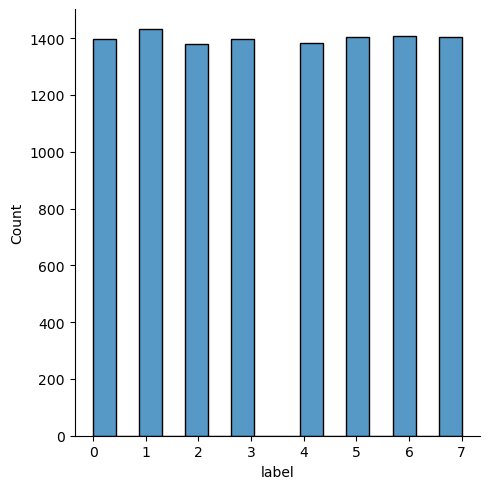

In [115]:
sns.displot(dataset.label)
plt.show()

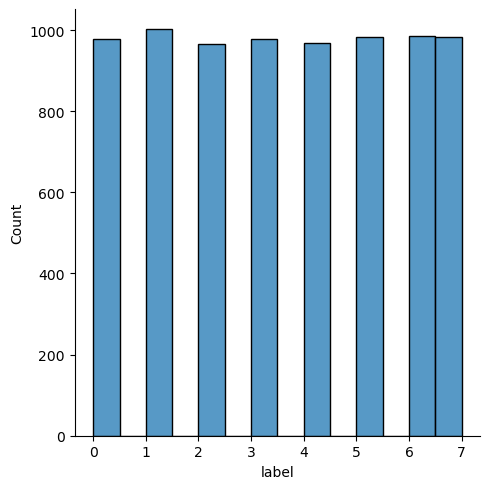

In [116]:
sns.displot(train_dataset.label)
plt.show()

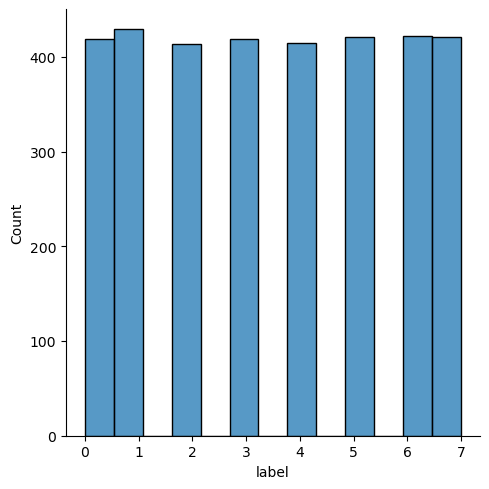

In [117]:
sns.displot(val_dataset.label)
plt.show()

In [118]:
torch.manual_seed(17)

In [119]:
class ComidasDataset(Dataset):
    def __init__(self, annotations_file : pd.DataFrame, transform=None, target_transform=None):
        self.img_labels = annotations_file
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        img_path = self.img_labels.iloc[idx, 0]
        img_path = dir_imagenes + os.path.basename(img_path)
        image = Img.open(img_path).convert('RGB')
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [120]:
transform = transforms.Compose([
    transforms.Resize(size=(400,400)),
    transforms.RandomResizedCrop(300),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip()
])

In [121]:
dat_train = ComidasDataset( train_dataset, transform=transform )
val_test = ComidasDataset( val_dataset, transform=transform )


In [122]:
""" Muy importante:
    Aqui se decide el batch size, que despues se incluye en la capa lineal
"""
train_dataloader = DataLoader(dat_train, batch_size=10, shuffle=True)
val_dataloader = DataLoader(val_test, batch_size=10, shuffle=True)

In [123]:
# base de rnn sacada de https://learn.microsoft.com/en-us/windows/ai/windows-ml/tutorials/pytorch-train-model


# Define a convolution neural network
# Variotanal autoencoder ?
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        # se han usadp kernels de 3x3 para no complicar los calculos de dimensiones
        
        # in_channes = 3 colores (RGB)
        # out_channes = salidad de la convolucion (3*4)? 
        # kernes_size = tamaño de la cuadricula de convolucion
        # stride = pasos que se mueve la convolucion
        # padding = bode generado para no perder features en los extremos
        # Sacal un featuremap de 12 canales: [batchx12x512x512}
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(12)

        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(12)
        # max pool reduce las dimensiones del featuremp
        # salida = [batchx12x64x64]
        self.pool = nn.MaxPool2d(2, 2)

        # salida = [batchx24x64x64]
        self.conv4 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(24)
        
        # salida = [batchx24x64x64]
        self.conv5 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(24)

        #test, no se usa en el resultado
        self.flat = nn.Flatten()

        self.fc2 = nn.Linear(24*150*150, 128)
        self.fc1 = nn.Linear(128, 8)
        
        
        
    def forward(self, input):
        # fase 1 se pasa el output de la convolucion a BatchNorm y a ReLu
        output = F.relu(self.bn1(self.conv1(input)))
        output = F.relu(self.bn2(self.conv2(output)))
        output = self.pool(output)
        output = F.relu(self.bn4(self.conv4(output)))
        output = F.relu(self.bn5(self.conv5(output)))
        #print(output.size())
        output = output.view(-1, 24*150*150)
        #print(output.size())
        output = self.fc2(output)
        output = self.fc1(output)
        return output


# Instantiate a neural network model 
model = Network()

In [124]:
device = device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device}: --> {torch.cuda.get_device_name(device)} device")

Using cuda:0: --> NVIDIA GeForce RTX 3050 Ti Laptop GPU device


In [125]:
# Funciones base sacadas de https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
def train_loop(dataloader, model, loss_fn, optimizer):
    best_accuracy = 0.0
    
    # Define your execution device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # device = xm.xla_device()
    print("The model will be running on", device, "device")
    # Convert model parameters and buffers to CPU or Cuda
    model = model.to(device)
    size = len(dataloader.dataset)

    for batch, (images, label) in enumerate(dataloader):
        # get the inputs
        #X = Variable(torch.tensor(images))
        images = images.to(device)
        y = Variable(label.to(device))

        # Compute prediction and loss
        pred = model(images)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print(batch)
        # print cada 2 batches = 2 * 1024 = 2048 imagenes
        if batch % 5 == 0:
            loss, current = loss.item(), (batch + 1) * len(images)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Define your execution device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # device = xm.xla_device()

    # matriz de confusion
    y_pred = []
    y_true = []


    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)

            pred = model(X)
            '''
            output = (torch.max(torch.exp(pred), 1)[1]).data.cpu().numpy()

            y_pred.extend(output) # Save Prediction
        
            labels = labels.data.cpu().numpy()
            y_true.extend(labels) # Save Truth
            '''
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    '''
    conf_matrix = confusion_matrix(y_true, y_pred)
    print("Confusion")
    print(conf_matrix)
    '''

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return (100*correct)

In [126]:
# model.load_state_dict(torch.load(drive+f"model_13896134932304.pth"))

print(f"Utilizando: {torch.cuda.get_device_name(torch.cuda.current_device())}")
torch.cuda.empty_cache()
print(torch.cuda.memory_summary(device=None, abbreviated=False))

Utilizando: NVIDIA GeForce RTX 3050 Ti Laptop GPU
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    1056 MB |    2132 MB |   77843 MB |   76786 MB |
|       from large pool |    1056 MB |    2132 MB |   77833 MB |   76777 MB |
|       from small pool |       0 MB |       0 MB |       9 MB |       9 MB |
|---------------------------------------------------------------------------|
| Active memory         |    1056 MB |    2132 MB |   77843 MB |   76786 MB |
|       from l

In [127]:
from torch.optim import Adam

learning_rate = 0.0001
# Define the loss function with Classification Cross-Entropy loss and an optimizer with Adam optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)

epochs = 100
best_val_acc = 0
val_acc = 0
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    val_acc = test_loop(val_dataloader, model, loss_fn)
    best_val_acc = max(best_val_acc, val_acc)

    if t+1 % 10 == 0:
        torch.save(model.state_dict(),
                   f"./models/model_{time.monotonic_ns()}.pth")

    if best_val_acc - val_acc > 5:
        print(
            f"Detenido proceso de training por error de validación, mejor accuracy obtenido: {best_val_acc}")
        torch.save(model.state_dict(),
                   f"./models/model_{time.monotonic_ns()}_last.pth")
        break

else:
    print("Finalizadas Epochs!")
torch.save(model.state_dict(), f"./models/model_{time.monotonic_ns()}_last.pth")

Epoch 1
-------------------------------
The model will be running on cuda:0 device
loss: 2.151172  [   10/ 7840]
loss: 44.058300  [   60/ 7840]
loss: 37.911644  [  110/ 7840]
loss: 12.243546  [  160/ 7840]
loss: 25.991186  [  210/ 7840]
loss: 28.477549  [  260/ 7840]
loss: 20.234348  [  310/ 7840]
loss: 7.641192  [  360/ 7840]
loss: 17.123966  [  410/ 7840]
loss: 24.842758  [  460/ 7840]
loss: 15.740812  [  510/ 7840]
loss: 11.243592  [  560/ 7840]
loss: 7.077601  [  610/ 7840]
loss: 13.079198  [  660/ 7840]
loss: 14.606054  [  710/ 7840]
loss: 7.281945  [  760/ 7840]
loss: 12.895742  [  810/ 7840]
loss: 11.146671  [  860/ 7840]
loss: 10.203199  [  910/ 7840]
loss: 10.796916  [  960/ 7840]
loss: 12.007013  [ 1010/ 7840]
loss: 12.736365  [ 1060/ 7840]
loss: 7.732976  [ 1110/ 7840]
loss: 10.475569  [ 1160/ 7840]
loss: 8.635895  [ 1210/ 7840]
loss: 9.939134  [ 1260/ 7840]
loss: 5.362175  [ 1310/ 7840]
loss: 5.695061  [ 1360/ 7840]
loss: 6.258940  [ 1410/ 7840]
loss: 10.275100  [ 1460/ 784

c:\Users\mario\anaconda3\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


loss: 3.021433  [ 2460/ 7840]
loss: 6.342390  [ 2510/ 7840]
loss: 3.922500  [ 2560/ 7840]
loss: 5.802271  [ 2610/ 7840]
loss: 4.265491  [ 2660/ 7840]
loss: 5.388730  [ 2710/ 7840]
loss: 8.583364  [ 2760/ 7840]
loss: 9.156323  [ 2810/ 7840]
loss: 5.289407  [ 2860/ 7840]
loss: 3.962800  [ 2910/ 7840]
loss: 6.913213  [ 2960/ 7840]
loss: 4.153828  [ 3010/ 7840]
loss: 4.221882  [ 3060/ 7840]
loss: 8.914702  [ 3110/ 7840]
loss: 6.549572  [ 3160/ 7840]
loss: 7.349458  [ 3210/ 7840]
loss: 6.270299  [ 3260/ 7840]
loss: 5.458505  [ 3310/ 7840]
loss: 5.528977  [ 3360/ 7840]
loss: 7.789519  [ 3410/ 7840]
loss: 7.245652  [ 3460/ 7840]
loss: 5.225770  [ 3510/ 7840]
loss: 5.131296  [ 3560/ 7840]
loss: 5.703302  [ 3610/ 7840]
loss: 5.050707  [ 3660/ 7840]
loss: 2.845273  [ 3710/ 7840]
loss: 6.985898  [ 3760/ 7840]
loss: 8.515829  [ 3810/ 7840]
loss: 3.645157  [ 3860/ 7840]
loss: 4.382460  [ 3910/ 7840]
loss: 4.649687  [ 3960/ 7840]
loss: 7.355355  [ 4010/ 7840]
loss: 1.895336  [ 4060/ 7840]
loss: 7.18

KeyboardInterrupt: 

In [ ]:
#@title Give me a name {display-mode: "form"}

# This code will be hidden when the notebook is loaded.

In [ ]:
now = time.time()
date_time = datetime.fromtimestamp(now)
torch.save(model.state_dict(), f"./models/model_{date_time.strftime('%m-%d_%H-%M').replace(' ','')}_manual.pth")

In [128]:
torch.cuda.empty_cache() # PyTorch thing

In [129]:
import gc
gc.collect() # Python thing

241

In [130]:
def choose_file_from_folder(folder_path):
    """
    Displays a menu to choose a file in a folder.

    Args:
        folder_path (str): The path to the folder.

    Returns:
        str: The path to the chosen file.
    """
    files = glob.glob(os.path.join(folder_path, "*"))
    file_menu = "\n".join([f"{i}. {file}" for i, file in enumerate(files, start=1)])
    print(f"Please choose a file from the following options:\n{file_menu}")
    choice = input("> ")
    while not choice.isdigit() or int(choice) not in range(1, len(files) + 1):
        print("Invalid choice. Please choose a valid option.")
        choice = input("> ")
    return files[int(choice) - 1]

In [131]:
model = Network()

model.load_state_dict(torch.load(choose_file_from_folder(model_dir)))

Please choose a file from the following options:
1. ./models\model_03-13_21-55_manual.pth
2. ./models\model_03-14_11-30_manual.pth
3. ./models\model_7014328000000manual.pth
4. ./models\model_8938375000000.pth
5. ./models\model_manual.pth


<All keys matched successfully>

In [132]:
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in val_dataloader:
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

KeyboardInterrupt: 

[[215  19  20  24  12   9  59  61]
 [ 33 236  18  30   9  29  15  59]
 [ 20  11 305   7  16  17  16  22]
 [ 18  35  13 219  26  20  18  70]
 [ 51  22  36  48 129  37  30  62]
 [ 12  33  14  17  19 241  32  53]
 [ 79  29  29  21  13  30 145  76]
 [ 28  15  11  16   9  26  28 288]]


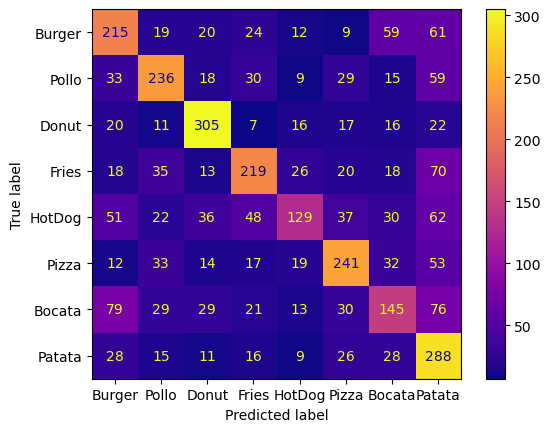

In [ ]:
# Calcular la matriz de confusión
labels = ["Burger","Pollo","Donut","Fries","HotDog","Pizza","Bocata","Patata"]
conf_matrix = confusion_matrix(y_true, y_pred)
print(conf_matrix)


disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)

disp.plot(cmap='plasma')

plt.show()

## Pasamos los datos de test por el modelo

In [133]:
class TestDataset(Dataset):
    def __init__(self, file : pd.DataFrame, transform=None, target_transform=None):
        self.imgs = file
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        # img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        img_path = self.imgs.iloc[idx, 0]
        img_path = dir_imagenes + os.path.basename(img_path)
        image = Img.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return int(idx),image
    


In [134]:
model = Network()

model.load_state_dict(torch.load(choose_file_from_folder(model_dir)))

test_data : pd.DataFrame = pd.read_csv(archivo_test, index_col=0)

dat_test = TestDataset( test_data, transform=transform )
test_dataloader = DataLoader(dat_test, batch_size=1, shuffle=False)


Please choose a file from the following options:
1. ./models\model_03-13_21-55_manual.pth
2. ./models\model_03-14_11-30_manual.pth
3. ./models\model_7014328000000manual.pth
4. ./models\model_8938375000000.pth
5. ./models\model_manual.pth


In [135]:
preds = {"target":{}}

# iterate over test data
for idx,inputs in test_dataloader:
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        preds["target"][f"{idx[0]}"]=int(output[0])

        # preds.extend(output) # Save Prediction

with open("results.json", "w") as results:
        json.dump(preds, results, indent=)


c:\Users\mario\anaconda3\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
